In [2]:
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

Cloning into 'clothing-dataset'...
remote: Enumerating objects: 5792, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 5792 (delta 13), reused 3 (delta 1), pack-reused 5766
Receiving objects: 100% (5792/5792), 152.92 MiB | 39.77 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import ResNet50, VGG16

In [4]:
labels = pd.read_csv("clothing-dataset/images.csv")
labels

image  sender_id     label   kids
0     4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1     ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2     00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3     ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4     3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False
...                                    ...        ...       ...    ...
5398  dfd4079d-967b-4b3e-8574-fbac11b58103        204    Shorts  False
5399  befa14be-8140-4faf-8061-1039947e329d        204      Body   True
5400  5379356a-40ee-4890-b416-2336a7d84061        310    Shorts  False
5401  65507fb8-3456-4c15-b53e-d1b03bf71a59        204     Shoes  False
5402  32b99302-cec7-4dec-adfa-3d4029674209        204     Skirt  False

[5403 rows x 4 columns]

In [5]:
images = labels["image"]
common_images=[]
for i in images:
    if i+".jpg" not in os.listdir("clothing-dataset/images/"):
        continue
    common_images.append(i)

In [6]:
def random_image(n,label):
    fig,axs = plt.subplots(nrows=1,ncols=n)
    for i in range(n):
        ind = random.choice(labels[labels["label"]==label]["image"].values)
        if ind not in common_images:
            continue
        img = Image.open("clothing-dataset/images/"+ind+".jpg")
        img = img.resize((128,128))
        # img = img.convert("L")
        img = np.array(img)
        axs[i].set_title(label)
        axs[i].imshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])


In [7]:
labels["label"].value_counts()

label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='label'>

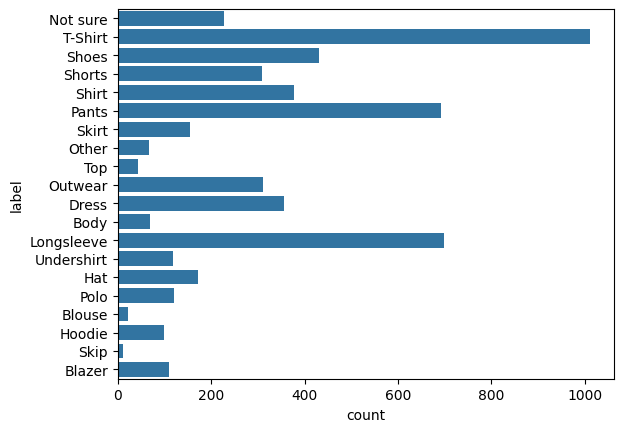

In [8]:
sns.countplot(labels["label"])

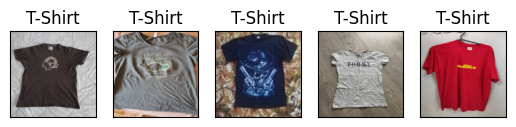

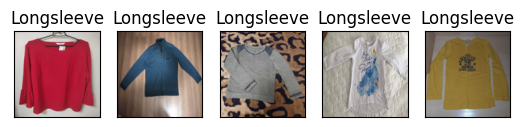

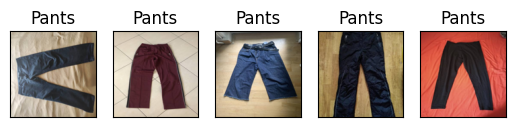

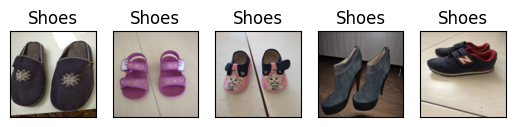

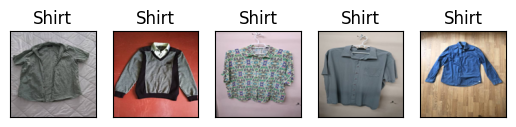

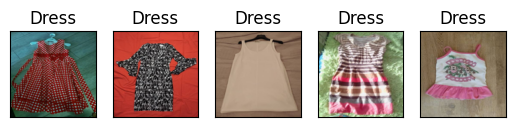

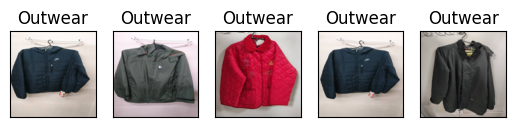

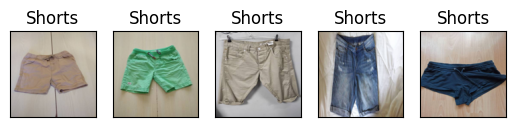

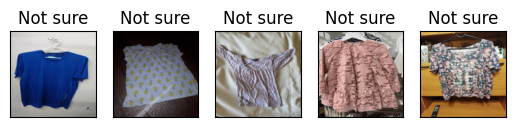

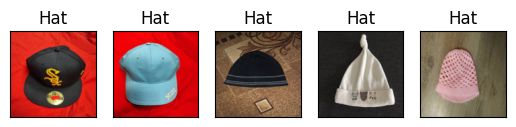

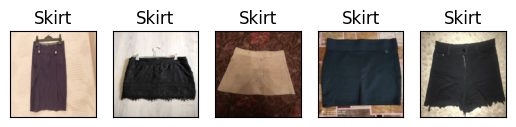

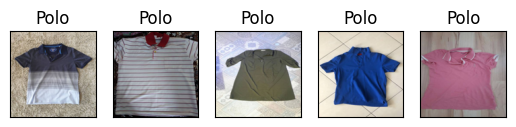

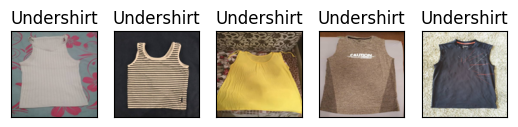

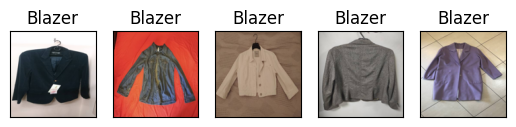

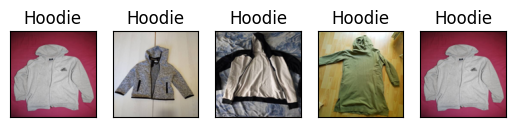

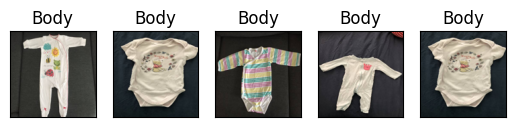

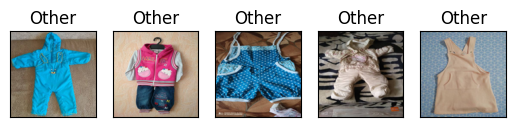

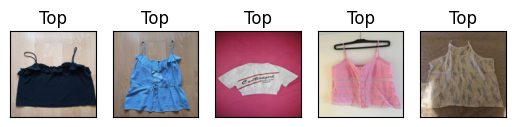

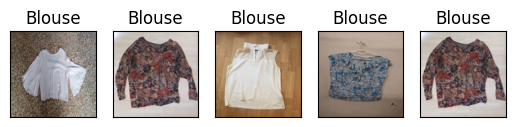

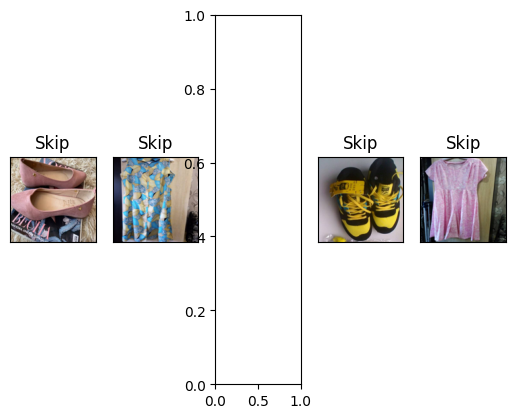

In [9]:
for i in labels["label"].value_counts().index:
    random_image(5,i)

In [10]:
labels_to_remove = ['Skip', 'Not sure', 'Other',"Blouse","Top","Body","Hoodie","Blazer","Undershirt","Polo","Skirt","Hat"]
labels = labels[~labels['label'].isin(labels_to_remove)]

In [11]:
labels["label"].value_counts()

label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Name: count, dtype: int64

In [12]:
classes = labels["label"].unique()

In [13]:
class_dict = dict(zip(range(len(classes)),classes))
class_dict

{0: 'T-Shirt',
 1: 'Shoes',
 2: 'Shorts',
 3: 'Shirt',
 4: 'Pants',
 5: 'Outwear',
 6: 'Dress',
 7: 'Longsleeve'}

In [14]:
class_wt = dict(zip(classes,range(len(classes))))
class_wt

{'T-Shirt': 0,
 'Shoes': 1,
 'Shorts': 2,
 'Shirt': 3,
 'Pants': 4,
 'Outwear': 5,
 'Dress': 6,
 'Longsleeve': 7}

In [15]:
labels.shape

(4188, 4)

In [16]:
# images = labels["image"]
# for i in images:
#     if i+".jpg" not in os.listdir("./images/"):
#         print("Missing Image")
#         break


In [17]:
def augument_class_upsample(label,batch,datagen):
    class_images=[]
    for i in labels[labels["label"]==label]["image"]:
        img = Image.open("clothing-dataset/images/"+i+".jpg")
        img = img.resize((128,128))
        img = np.array(img)
        class_images.append(img)
    class_images = np.array(class_images)
    aug = datagen.flow(class_images,batch_size=batch,shuffle=True)
    return aug
def augument_class_downsample(label,batch,datagen):
    class_images=[]
    random_sample = random.sample(set(labels[labels["label"]==label]["image"].values),batch)
    for i in random_sample:
        img = Image.open("clothing-dataset/images/"+i+".jpg")
        img = img.resize((128,128))
        img = np.array(img))
        class_images.append(img)
    class_images = np.array(class_images)
    aug = datagen.flow(class_images,batch_size=batch,shuffle=True)
    return aug

In [18]:
def augument(label,mean_sample):
    if labels["label"].value_counts()[label] < mean_sample:
        datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                brightness_range=[0.5,1.5],
                fill_mode='nearest'
                )
        return augument_class_upsample(label,40,datagen)
    else:
        datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                brightness_range=[0.5,1.5],
                fill_mode='nearest'
                )
        return augument_class_downsample(label,mean_sample,datagen)


In [19]:
def data_generator(mean_sample):
    X=[]
    y=[]
    vc={}
    for i in labels["label"].unique():
        aug = augument(i,32)
        batch = aug.next()
        X.extend(batch)
    #     for j in range(len(batch)):
    #         folder_name = "train/"+i
    #         if not os.path.exists(folder_name):
    #             os.makedirs(folder_name)
    #         img_name = str(j)+".jpg"
    #         image_path = os.path.join(folder_name, img_name)
    # #         print(np.squeeze(batch[j]))
    #         image = Image.fromarray(np.squeeze(batch[j]).astype(np.uint8))
    #         image.save(image_path)
        temp = len(batch)
        while(temp<=(mean_sample)):
            imgs = aug.next()
                # for j in range(len(imgs)):
                #     folder_name = "train/"+i
                #     if not os.path.exists(folder_name):
                #         os.makedirs(folder_name)
                #     img_name = str(j+temp)+".jpg"
                #     image_path = os.path.join(folder_name, img_name)
                #     image = Image.fromarray(np.squeeze(imgs[j]).astype(np.uint8))
                #     image.save(image_path)
            X.extend(imgs)
            temp+=len(imgs)
        vc[i]=temp
        y.extend(np.full(temp,class_wt[i]))
    #     print(len(X_train),len(y_train))
    X = np.array(X)
    y = np.array(tf.keras.utils.to_categorical(y))
    return X,y,vc

In [20]:
X_train,y_train,vc_train = data_generator(500)

In [21]:
print(X_train.shape,y_train.shape)

(4096, 128, 128, 3) (4096, 8)


<BarContainer object of 8 artists>

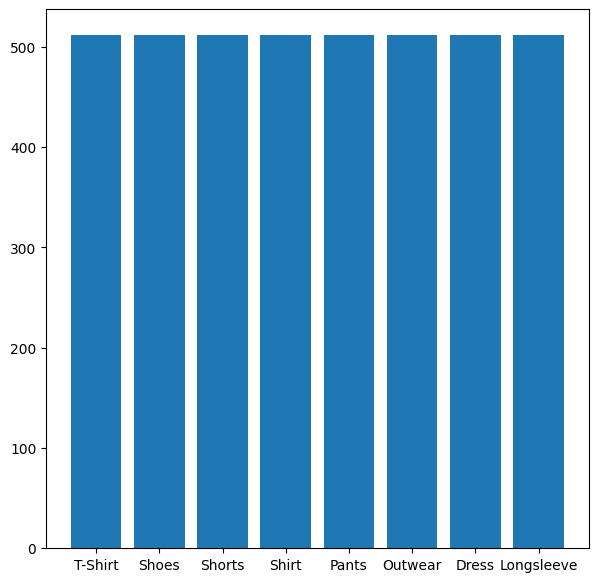

In [22]:
plt.figure(figsize=(7,7))
plt.bar(height=vc_train.values(),x = vc_train.keys())

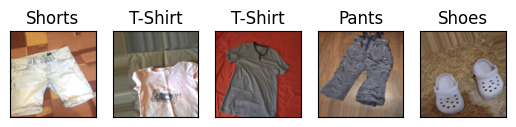

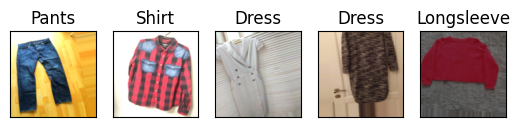

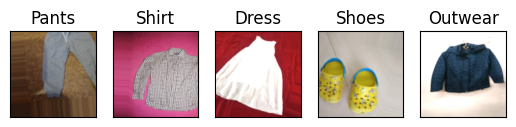

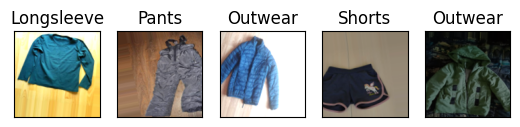

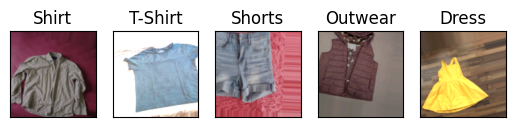

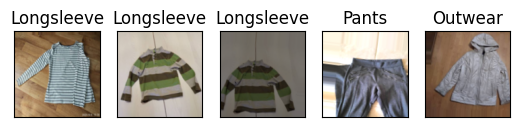

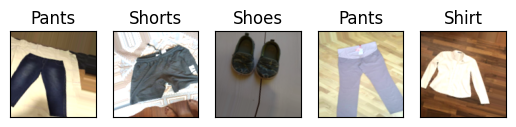

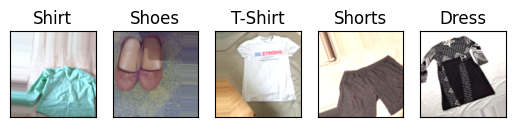

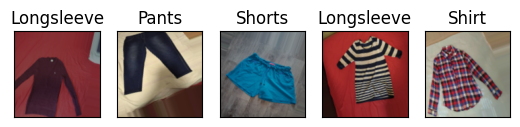

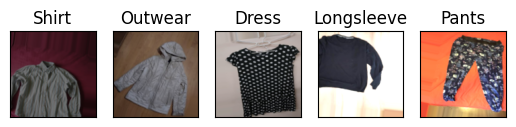

In [23]:
#plot random image from X_train(after augumentation)
for i in range(10):
  fig,axs = plt.subplots(nrows=1,ncols=5)
  for j in range(5):
      ind = random.choice(range(len(X_train)))
      axs[j].set_title(class_dict[np.argmax(y_train[ind])])
      axs[j].imshow(X_train[ind])
      axs[j].set_xticks([])
      axs[j].set_yticks([])

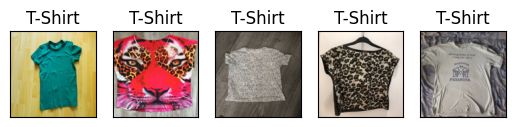

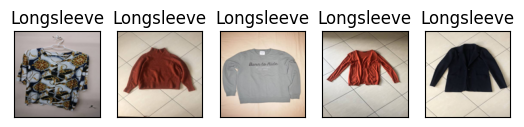

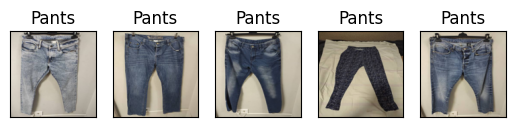

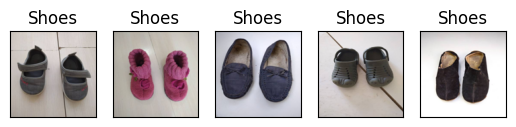

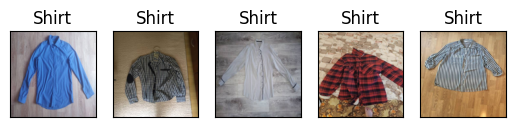

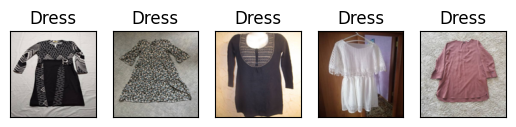

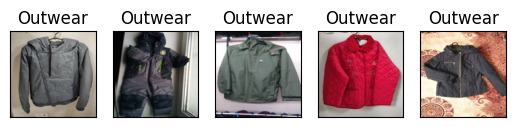

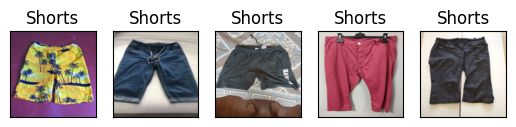

In [24]:
#plotting original images from dataset
for i in labels["label"].value_counts().index:
    random_image(5,i)

In [25]:
X_val,y_val,vc_val = data_generator(32)

In [26]:
print(X_val.shape,y_val.shape)

(512, 128, 128, 3) (512, 8)


<BarContainer object of 8 artists>

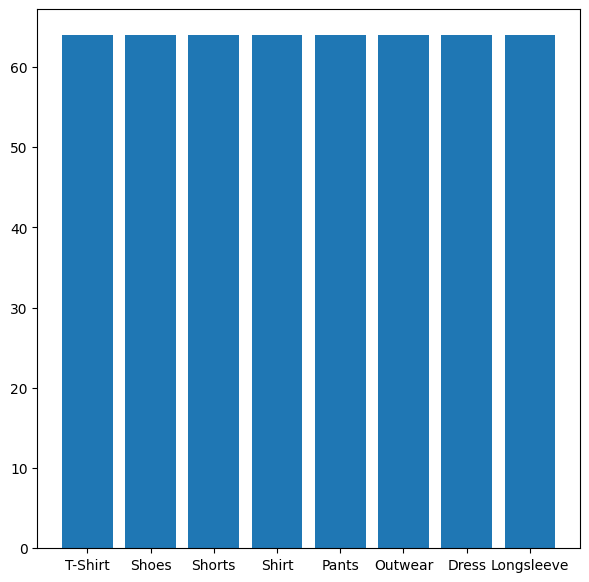

In [27]:
plt.figure(figsize=(7,7))
plt.bar(height=vc_val.values(),x = vc_val.keys())

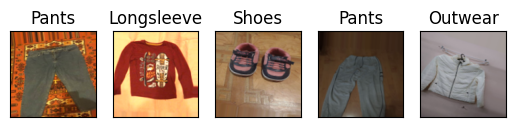

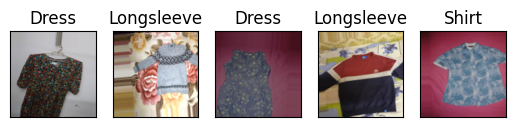

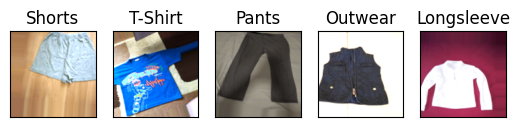

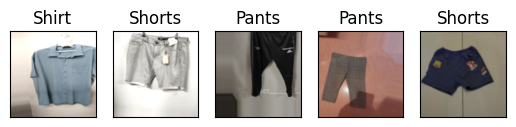

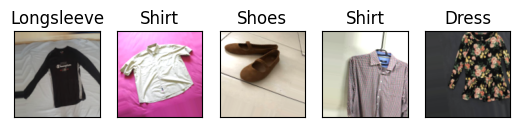

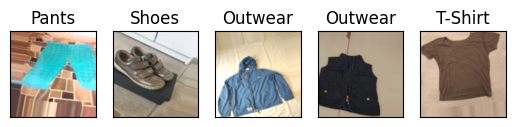

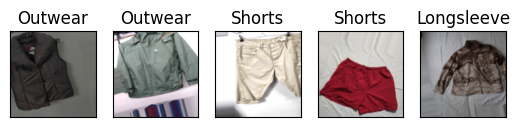

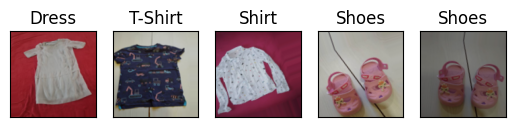

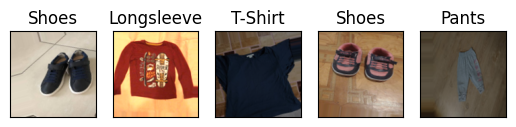

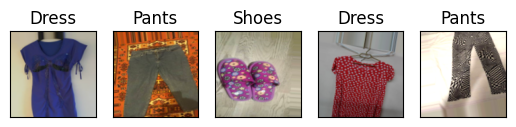

In [28]:
# plot random image from X_test(after augumentation)
for i in range(10):
  fig,axs = plt.subplots(nrows=1,ncols=5)
  for j in range(5):
      ind = random.choice(range(len(X_val)))
      axs[j].set_title(class_dict[np.argmax(y_val[ind])])
      axs[j].imshow(X_val[ind])
      axs[j].set_xticks([])
      axs[j].set_yticks([])

In [29]:
# Insted of manually augumenting we can use flow from dataframe to generate train and validation images
def Image_Generator():
  labels["images"] = labels["image"]+".jpg"
  train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.1,
                                    brightness_range=[0.5,1.5]
                                    # preprocessing_function=rgb_to_gray
                                    )

  train_generator = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory="clothing-dataset/images/",
      x_col='images',
      y_col='label',
      target_size=(128,128),
      class_mode='categorical',
      batch_size=32,
      shuffle=True,
      subset='training'
  )

  validation_generator = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory="clothing-dataset/images/",
      x_col='images',
      y_col='label',
      target_size=(128,128),
      class_mode='categorical',
      batch_size=32,
      shuffle=True,
      subset='validation'
  )
  return train_generator,validation_generator

In [99]:
def data_without_augumentation():
  X=[]
  y=[]
  for i in labels.index:
      img = Image.open("clothing-dataset/images/"+labels.loc[i,"image"]+".jpg")
      # img = img.convert("L")
      img = img.resize((128,128))
      img = np.array(img)
#         print(img.shape)
#         print(np.expand_dims(img,axis=-1).shape)
      X.append(img)
      y.append(class_wt[labels.loc[i,"label"]])
  X = np.array(X)
  y = np.array(tf.keras.utils.to_categorical(y))
  return X,y

In [100]:
#X and y are raw images from dataset
X,y = data_without_augumentation()

In [101]:
X.shape,y.shape

((4188, 128, 128, 3), (4188, 8))

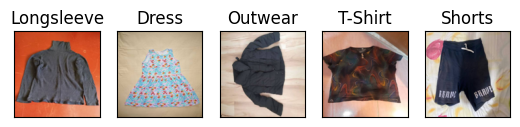

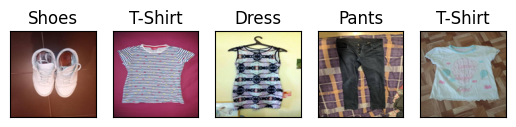

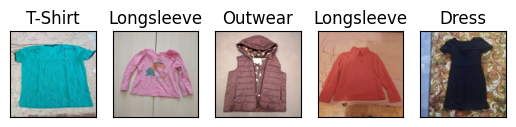

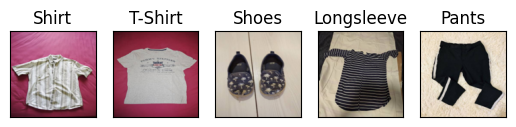

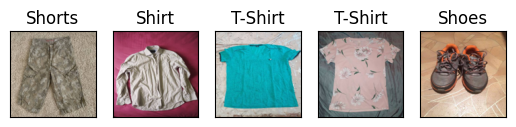

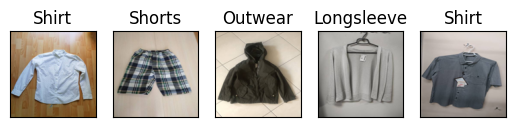

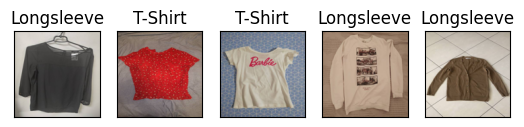

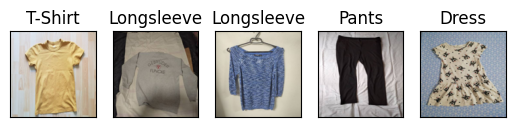

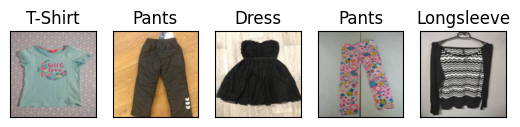

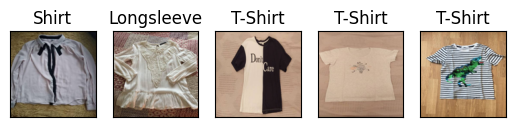

In [33]:
# plot random image from Dataset(without augumentation)
for i in range(10):
  fig,axs = plt.subplots(nrows=1,ncols=5)
  for j in range(5):
      ind = random.choice(range(len(X)))
      axs[j].set_title(class_dict[np.argmax(y[ind])])
      axs[j].imshow(X[ind])
      axs[j].set_xticks([])
      axs[j].set_yticks([])

#Built a custom model with deep convolution layers as well as tried transfer learning with some of the pretrained existing models
#(mobilenet,resnet,VGG)

In [34]:
def build_model(key,model_name=None):
    if (key=="transfer"):
      if (model_name=="mobilenet"):
          pre_trained_model = MobileNetV2(input_shape=(128 ,128, 3),
                                      include_top=False,
                                      weights='imagenet')
      if (model_name=="resnet"):
          pre_trained_model = ResNet50(input_shape=(128 ,128, 3),
                                      include_top=False,
                                      weights='imagenet')
      if (model_name=="vgg"):
          pre_trained_model = VGG16(input_shape=(128 ,128, 3),
                                      include_top=False,
                                      weights='imagenet')
      for layer in pre_trained_model.layers:
          layer.trainable = True
      last_layer = pre_trained_model.get_layer(pre_trained_model.layers[-1].name)
      last_output = last_layer.output
      x = tf.keras.layers.Flatten()(last_output)
      x2 = tf.keras.layers.Dropout(0.5)(x)
      x3 = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer="l2")(x2)
      x4 = tf.keras.layers.Dropout(0.5)(x3)
      x7 = tf.keras.layers.Dense(8, activation='softmax')(x4)
      model = tf.keras.models.Model(pre_trained_model.input, x7)
    if key=="custom":
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(32,(2,2),strides=(2,2),input_shape=(128,128,3),activation="relu"))
        model.add(tf.keras.layers.DepthwiseConv2D((2,2),activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Conv2D(64,(2,2),activation="relu"))
        model.add(tf.keras.layers.DepthwiseConv2D((2,2),strides=(2,2),activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Conv2D(128,(2,2),strides=(2,2),activation="relu"))
        model.add(tf.keras.layers.DepthwiseConv2D((2,2),activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Conv2D(256,(2,2),activation="relu"))
        model.add(tf.keras.layers.DepthwiseConv2D((2,2),strides=(2,2),activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Conv2D(512,(2,2),strides=(2,2),activation="relu"))
        model.add(tf.keras.layers.DepthwiseConv2D((2,2),activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.DepthwiseConv2D((2,2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=256,activation="relu",kernel_regularizer="l2"))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(units=128,activation="relu",kernel_regularizer="l2"))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(units=64,activation="relu",kernel_regularizer="l2"))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(units=32,activation="relu",kernel_regularizer="l2"))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(units=8,activation="softmax"))

    return model

In [40]:
def run_model(Epochs,model_name,data_aug=False,generator=True):
    if data_aug:
      if generator:
        early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
        train_generator,validation_generator = Image_Generator()
        k = train_generator.class_indices
        class_weights={k['Longsleeve']:1.44,k['Dress']:2.83,k['Outwear']:3.24,k["Pants"]:1.46,k['Shirt']:2.67,k['Shorts']:3.28,k['Shoes']:2.34,k['T-Shirt']:1}
        check = ModelCheckpoint(model_name, save_best_only=True)
        Reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)
        model_history = model.fit(train_generator, epochs=Epochs,validation_data=validation_generator,callbacks=[early_stopping,Reduce_lr,check],class_weight=class_weights)

      else:
        early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
        check = ModelCheckpoint(model_name, save_best_only=True)
        Reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)
        model_history = model.fit(X_train,y_train,epochs=Epochs,validation_data=(X_val,y_val),callbacks=[early_stopping,Reduce_lr,check])

    else:
      early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
      k = class_wt
      class_weights={k['Longsleeve']:1.44,k['Dress']:2.83,k['Outwear']:3.24,k["Pants"]:1.46,k['Shirt']:2.67,k['Shorts']:3.28,k['Shoes']:2.34,k['T-Shirt']:1}
      check = ModelCheckpoint(model_name, save_best_only=True)
      Reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)
      model_history = model.fit(X, y,epochs=Epochs,validation_split=0.1,shuffle=True,callbacks=[early_stopping,Reduce_lr,check],class_weight=class_weights)

    return model_history

In [41]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [43]:
# model = build_model("transfer",model_name="mobilenet")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with No Data Augumentation(mobilenet)")
# plot_loss_curves(run_model(50,"no_augumentation_mobile.h5"))

In [44]:
# model = build_model("transfer",model_name="resnet")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with No Data Augumentation(resnet)")
# plot_loss_curves(run_model(50,"no_augumentation_resnet.h5"))

In [45]:
# model = build_model("transfer",model_name="vgg")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with No Data Augumentation(vgg)")
# plot_loss_curves(run_model(50,"no_augumentation_vgg.h5"))

In [46]:
# model = build_model("custom")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with No Data Augumentation(custom)")
# plot_loss_curves(run_model(50,"no_augumentation_custom.h5"))

In [47]:
# model = build_model("transfer",model_name="mobilenet")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Manual Data Augumentation(mobilnet)")
# plot_loss_curves(run_model(50,"manual_aug_mobile.h5",data_aug=True,generator=False))

In [48]:
# model = build_model("transfer",model_name="resnet")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Manual Data Augumentation(resnet)")
# plot_loss_curves(run_model(50,"manual_aug_resnet.h5",data_aug=True,generator=False))

In [49]:
# model = build_model("transfer",model_name="vgg")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Manual Data Augumentation(vgg)")
# plot_loss_curves(run_model(50,"manual_aug_vgg.h5",data_aug=True,generator=False))

In [50]:
# model = build_model("custom")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Manual Data Augumentation(custom)")
# plot_loss_curves(run_model(50,"manual_aug_custom.h5",data_aug=True,generator=False))

In [51]:
# model = build_model("transfer",model_name="mobilenet")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Generator Augumentation(mobilenet)")
# plot_loss_curves(run_model(50,"gen_aug_mobile.h5",data_aug=True,generator=True))

In [52]:
# model = build_model("transfer",model_name="resnet")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Generator Augumentation(resnet)")
# plot_loss_curves(run_model(50,"gen_aug_resnet.h5",data_aug=True,generator=True))

In [53]:
# model = build_model("transfer",model_name="vgg")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Generator Augumentation(vgg)")
# plot_loss_curves(run_model(50,"gen_aug_vgg.h5",data_aug=True,generator=True))

In [54]:
# model = build_model("custom")
# # model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# print("Model with Generator Augumentation(custom)")
# plot_loss_curves(run_model(50,"gen_aug_custom.h5",data_aug=True,generator=True))

#All the above models were giving very poor results on training and validation. The data augumentation causes the classes to overlap making it difficult
for classification

#Hence a alternative approach to use edges of the images to improve model performance.

In [72]:
def random_edge(n,k,thr1,thr2):
  for i in range(n):
    fig,axs = plt.subplots(nrows=1,ncols=2)
    ind = random.choice(range(len(X)))
    image = X[ind]
    blurred = cv2.GaussianBlur(image, (k, k), 0)
    edges = cv2.Canny(blurred, thr1, thr2)
    axs[0].imshow(image)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(edges,cmap="gray")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
  cv2.waitKey(0)
  cv2.destroyAllWindows()

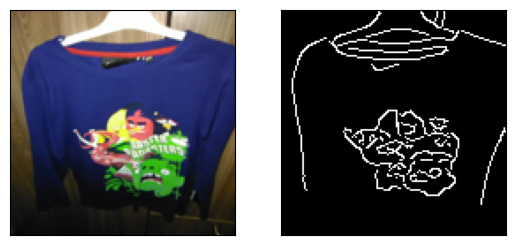

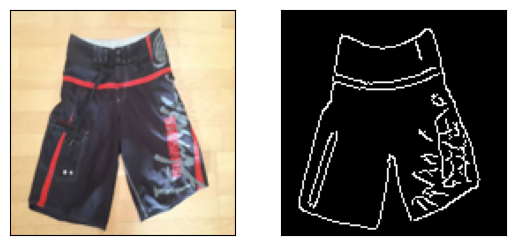

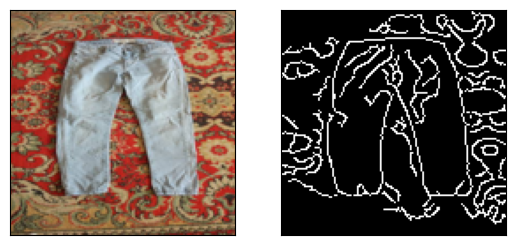

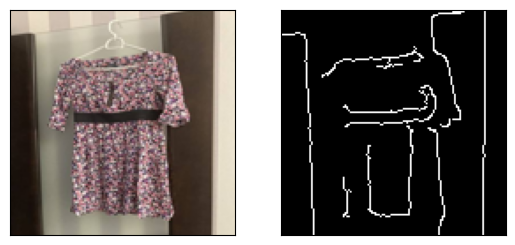

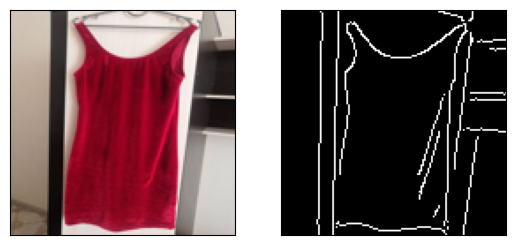

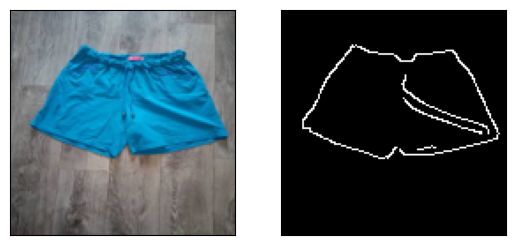

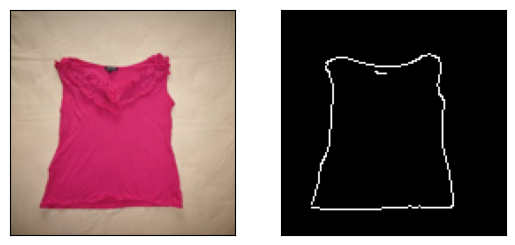

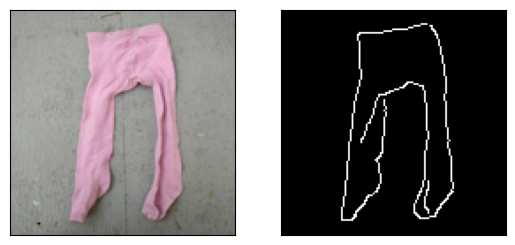

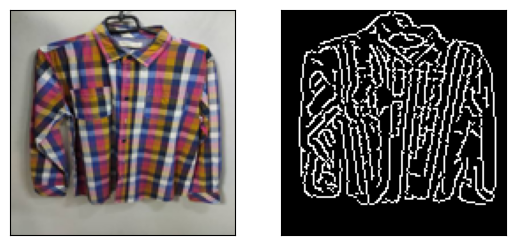

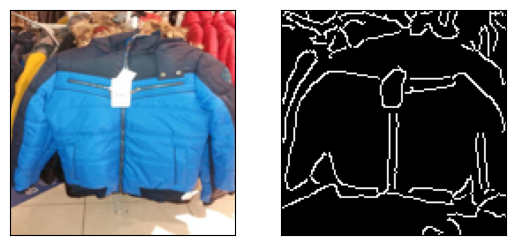

In [74]:
# give the edges of random images in the dataset
random_edge(10,9,thr1=50,thr2=150)

In [102]:
def data_for_edges(k,thr1,thr2):
  X_=[]
  for i in range(len(X)):
    image = X[i]
    blurred = cv2.GaussianBlur(image, (k, k), 0)
    edges = cv2.Canny(blurred, thr1, thr2)
    X_.append(np.expand_dims(edges,axis=-1))
  return np.array(X_)

In [103]:
X_edges = data_for_edges(9,50,150)
X_edges.shape

(4188, 128, 128, 1)

#build a model with 2 inputs one being the image and other being the edges

In [121]:
def build_model_for_edges():
  input_shape1 = (128, 128, 3)
  input_shape2 = (128, 128,1 )

  input1 = tf.keras.layers.Input(shape=input_shape1, name='input_image1')
  input2 = tf.keras.layers.Input(shape=input_shape2, name='input_image2')

  x1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',strides=(2,2))(input1)
  x1 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',strides=(2,2))(x1)
  x1 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',strides=(2,2))(x1)
  x1 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',strides=(2,2))(x1)
  x1 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.DepthwiseConv2D((5,5),activation="relu")(x1)
  x1 = tf.keras.layers.Flatten()(x1)

  x2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',strides=(2,2))(input2)
  x2 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x2)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu',strides=(2,2))(x2)
  x2 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x2)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',strides=(2,2))(x2)
  x2 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x2)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',strides=(2,2))(x2)
  x2 = tf.keras.layers.DepthwiseConv2D((2,2),activation="relu")(x2)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.DepthwiseConv2D((5,5),activation="relu")(x2)
  x2 = tf.keras.layers.Flatten()(x2)

  combined = tf.keras.layers.concatenate([x1, x2])

  x = tf.keras.layers.Dense(256, activation='relu')(combined)
  # x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  # x = tf.keras.layers.Dropout(0.4)(x)
  output = tf.keras.layers.Dense(8, activation='softmax')(x)

  model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
  return model

In [122]:
model = build_model_for_edges()
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image1 (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_image2 (InputLayer)   [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 63, 63, 64)           1792      ['input_image1[0][0]']        
                                                                                                  
 conv2d_102 (Conv2D)         (None, 63, 63, 64)           640       ['input_image2[0][0]']        
                                                                                           

In [123]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
# early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
k = class_wt
class_weights={k['Longsleeve']:1.44,k['Dress']:2.83,k['Outwear']:3.24,k["Pants"]:1.46,k['Shirt']:2.67,k['Shorts']:3.28,k['Shoes']:2.34,k['T-Shirt']:1}
check = ModelCheckpoint("model_with_edge.h5", save_best_only=True)
Reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)
model_history = model.fit([X,X_edges], y,epochs=50,validation_split=0.1,shuffle=True,callbacks=[Reduce_lr,check],class_weight=class_weights)


Epoch 1/50
118/118 [==============================] - 11s 28ms/step - loss: 3.1696 - accuracy: 0.4184 - val_loss: 6.2585 - val_accuracy: 0.3246 - lr: 0.0100
Epoch 2/50
118/118 [==============================] - 3s 24ms/step - loss: 2.4320 - accuracy: 0.5574 - val_loss: 1.5986 - val_accuracy: 0.5800 - lr: 0.0100
Epoch 3/50
118/118 [==============================] - 3s 23ms/step - loss: 2.0902 - accuracy: 0.6201 - val_loss: 1.8336 - val_accuracy: 0.5298 - lr: 0.0100
Epoch 4/50
118/118 [==============================] - 3s 25ms/step - loss: 1.8849 - accuracy: 0.6702 - val_loss: 1.2254 - val_accuracy: 0.6802 - lr: 0.0100
Epoch 5/50
118/118 [==============================] - 3s 25ms/step - loss: 1.7157 - accuracy: 0.7034 - val_loss: 0.9111 - val_accuracy: 0.7351 - lr: 0.0100
Epoch 6/50
118/118 [==============================] - 3s 23ms/step - loss: 1.5235 - accuracy: 0.7310 - val_loss: 1.1907 - val_accuracy: 0.6563 - lr: 0.0100
Epoch 7/50
118/118 [==============================] - 3s 25ms/s

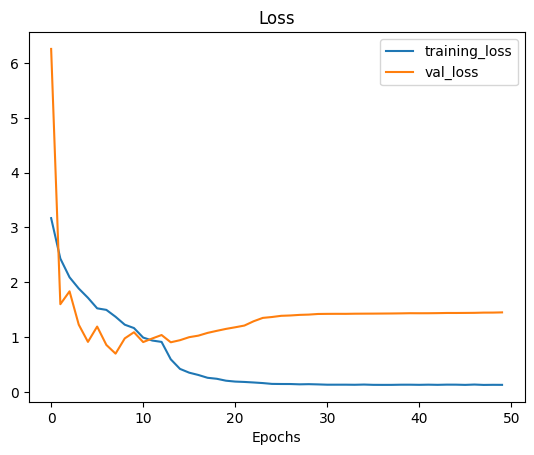

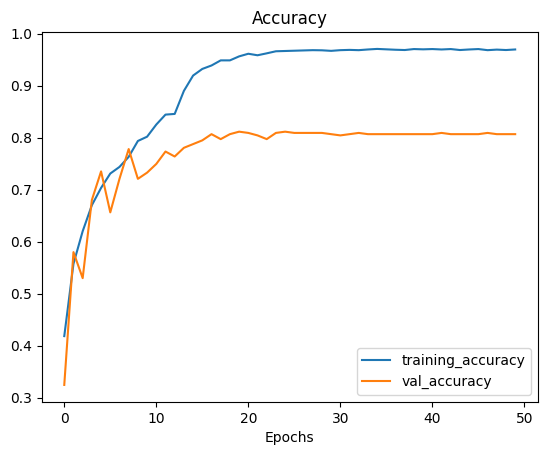

In [124]:
plot_loss_curves(model_history)

The model has 80 percentage validation accuracy

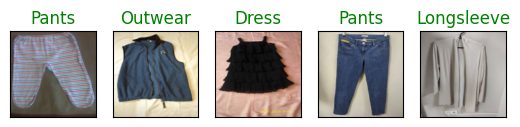

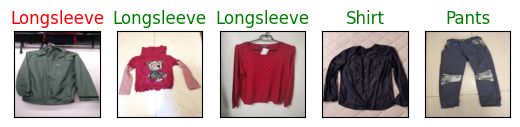

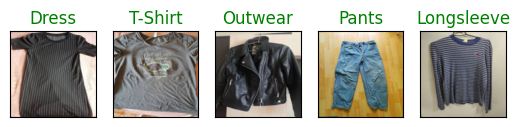

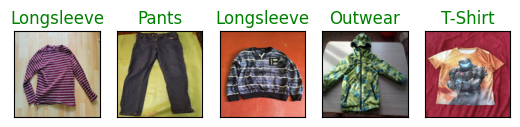

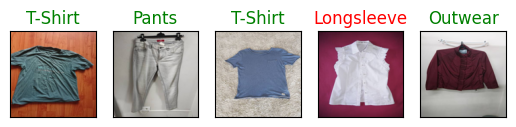

In [137]:
# random test on the images
for i in range(5):
  fig,axs = plt.subplots(nrows=1,ncols=5)
  for j in range(5):
      ind = random.choice(range(len(X)))
      inp1 = X[ind].reshape(1,128,128,3)
      image = X[ind]
      image = cv2.convertScaleAbs(image)
      blurred = cv2.GaussianBlur(image, (9, 9), 0)
      edges = cv2.Canny(blurred, 50, 150)
      inp2 = np.expand_dims(edges,axis=-1).reshape(1,128,128,1)
      pred = class_dict[np.argmax(model([inp1,inp2]))]
      act = class_dict[np.argmax(y[ind])]
      if (pred==act):
        axs[j].set_title(pred,color="green")
        axs[j].imshow(X[ind])
        axs[j].set_xticks([])
        axs[j].set_yticks([])
      else:
        axs[j].set_title(pred,color="red")
        axs[j].imshow(X[ind])
        axs[j].set_xticks([])
        axs[j].set_yticks([])